In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
print(grid_data_file)
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))

/home/lena/Promotion/neurolib/GUI/current/gui/bi.pickle
147


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
dur = 500.
t_pen = 0.96

In [5]:
folder = str(os.getcwd().split('data_2')[1])
case = str(folder[1])

In [6]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-10
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

p_var = [0]
wp = 1. / (dur - t_pen * dur)

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [13]:
bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 

initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

In [28]:
# get initial parameters and target states

i_range = [20]

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

-------  20 0.4500000000000001 0.4750000000000002


In [15]:
# get uncontrolled cost
data.set_parameters(aln)
c_var = [0,1]

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(wp, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  636.9058225135838
RUN  0 , total integrated cost =  636.9058225135838
Gradient descend method:  None
RUN  0 , total integrated cost =  636.9058225135838
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  797.1477718037709
RUN  0 , total integrated cost =  797.1477718037709
Gradient descend method:  None
RUN  0 , total integrated cost =  797.1477718037709
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  1 , total integrated cost =  48.6693338482971
RUN  2 , total integrated cost =  45.54433384829716
RUN  3 , total integrated cost =  45.489402207672086
RUN  4 , total integrated cost =  45.48883000308287
RUN  5 , total integrated cost =  45.4888047942782
RUN  6 , total integrated cost =  45.488804465877486
RUN  7 , total integrated cost =  45.48880425312615
RUN  8 , total integrated cost =  45.48880381168585
RUN  9 , total integrated cost =  45.48880358660309
RUN  10 , total integrated cost =  45.488803098731054
RUN  11 , total integrated cost =  45.44324480348499
RUN  12 , total integrated cost =  44.66199480347086
RUN  13 , total integrated cost =  44.6223219519081
RUN  14 , total integrated cost =  44.62127291015787
RUN  15 , total integrated cos

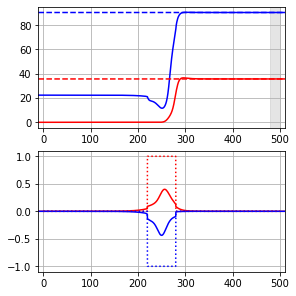

uncontrolled cost :  636.9058225135838
cost splitting :  0.0009673511699749905 [2.00521613 2.12007825]


In [127]:
cgv = None
j = 0

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    cost.setParams(wp, 0., 10.)
    max_it = int(29)

    control0[0,1,2200:2800] = -1.
    control0[0,0,2200:2800] = 1.

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
    ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
    ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
    ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
    ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
    ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
    ax[0].set_xlim(-dur_pre,dur+dur_post)
    ax[1].set_xlim(-dur_pre,dur+dur_post)
    ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    ax[1].plot(plot_time_array, control0[0,0,:], color = 'red', linestyle=':')
    ax[1].plot(plot_time_array, control0[0,1,:], color = 'blue', linestyle=':')
    plt.show()

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])    

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  44.62124994109744
RUN  0 , total integrated cost =  44.62124994109744
Gradient descend method:  None
RUN  1 , total integrated cost =  44.621249775100516
RUN  1 , total integrated cost =  44.621249775100516
Improved over  1  iterations in  1.4041696799686179  seconds by  3.7201316160917486e-07  percent.
cost splitting :  2.161058692884431e-06 [2.19150766 2.27061731]


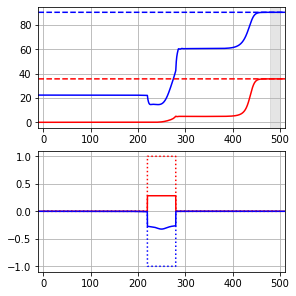

In [124]:
c_var = [0,1]
conv = [None] * len(exc)
max_it = int(1)

tol = 1e-9

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
        
    while not conv[i]:
            
        aln.params.duration = dur
        cost.setParams(wp, 0., 10.)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control1 = aln.getZeroControl()
        control1 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control1, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if max_it > 2:
            if cost_[i][2] == 0.:
                conv[i] = True

        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])

        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        ax[1].plot(plot_time_array, control0[0,0,:], color = 'red', linestyle=':')
        ax[1].plot(plot_time_array, control0[0,1,:], color = 'blue', linestyle=':')
        plt.show()
        
        break

-------  20 0.4500000000000001 0.4750000000000002


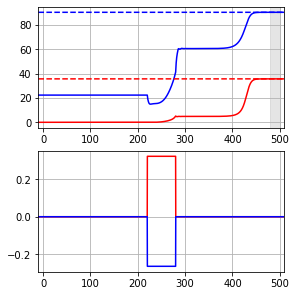

In [35]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    aln.params.duration = dur + dur_pre + dur_post

    time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
    ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
    ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
    ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
    ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
    ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
    ax[0].set_xlim(-dur_pre,dur+dur_post)
    ax[1].set_xlim(-dur_pre,dur+dur_post)
    ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()